In [19]:
import numpy as np
import os
import matplotlib.pyplot as plt
from nilearn import image
import nibabel as nib
import pandas as pd
from junifer.data import get_mask
import nibabel.processing as npr
from junifer.utils import logger
from nilearn.maskers import NiftiMasker
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [9]:
class GMVHistogramProcessor:
    def __init__(self, base_paths: list, bins: int, mask_file: str, save_to_hdf5: bool = False, hdf5_file_path: str = None):
        self.base_paths = base_paths
        self.bins = bins
        self.mask_file = mask_file
        self.save_to_hdf5 = save_to_hdf5
        self.hdf5_file_path = hdf5_file_path

    def file_reader(self, file_name: str) -> np.ndarray:
        """
        Reads the .nii.gz file and returns the voxel data as a flattened numpy array.
        """
        file = nib.load(file_name)
        data = file.get_fdata().ravel()
        return data

    def create_histograms(self, data: np.ndarray, bins: int) -> tuple:
        """
        Creates histograms from voxel data.
        """
        hist, bin_edges = np.histogram(data, bins)
        return hist, bin_edges

    def process_and_mask_image(self, sub_file: str) -> np.ndarray:
        """
        Processes the subject image by loading and masking the image data.
        Returns the voxel data after masking.
        """
        # Load the subject and mask images
        sub_img = nib.load(sub_file)
        mask_img = nib.load(self.mask_file)

        # Mask the subject image using NiftiMasker
        logger.debug("Masking")
        masker = NiftiMasker(mask_img, target_affine=sub_img.affine)
        data = masker.fit_transform(sub_img)
        
        # Flatten the masked data for histogram computation
        return data.ravel()

    def compute(self) -> pd.DataFrame:
        """
        Iterates over all subject images, processes them, and computes histograms.
        Returns a DataFrame with histogram data and bin edges.
        """
        histograms = [] 
        subjects = [] 
        bin_numbers = []

        # Wrap the base_paths iteration with tqdm for progress tracking
        for base_path in tqdm(self.base_paths, desc="Processing Subjects"):
            # Extract the subject folder name from the base path
            sub_folder = base_path.split('/')[-1]  # e.g., 'sub-IXI002'

            # Construct the full path to the .nii.gz file in the 'mri' folder
            sub_file = os.path.join(base_path, 'mri', f'm0wp1{sub_folder}.nii.gz')

            if os.path.exists(sub_file) and os.path.exists(self.mask_file):
                # Process the subject image and apply the mask
                logger.debug(f"Processing data for {sub_folder}")
                processed_data = self.process_and_mask_image(sub_file)

                # Create histogram from the processed data
                hist_data, bin_edges = self.create_histograms(processed_data, self.bins)
                
                # Append histogram data and subject ID to lists
                histograms.append(hist_data)
                subjects.append(sub_folder)
                bin_numbers.append(bin_edges)
            else:
                print(f"File not found: {sub_file} or {self.mask_file}")

        # Convert the histogram data to a pandas DataFrame
        df_hists = pd.DataFrame(histograms, index=subjects)
        df_bins = pd.DataFrame(bin_numbers, index=subjects)

        # Set the column names to indicate the bin ranges
        bin_labels = [f'Bin_{i}' for i in range(1, self.bins + 1)]
        df_hists.columns = bin_labels
        
        # Optionally save to HDF5 if the flag is enabled
        if self.save_to_hdf5 and self.hdf5_file_path:
            self.save_to_hdf5_file(df_hists, df_bins)
        
        return df_hists, df_bins

    def save_to_hdf5_file(self, df_hists: pd.DataFrame, df_bins: pd.DataFrame) -> None:
        """
        If the flag is enabled, saves the histogram and bin data as an HDF5 file to given path.
        """
        if self.hdf5_file_path:
            logger.debug(f"Saving DataFrames to HDF5 at {self.hdf5_file_path}")
            with pd.HDFStore(self.hdf5_file_path) as store:
                store.put('histograms', df_hists)
                store.put('bins', df_bins)
            #logger.info(f"Data saved to {self.hdf5_file_path}")
        else:
            print("No file path provided for saving HDF5 file.")
            #logger.debug("No file path provided for saving HDF5 file.")

    def plot_histogram_data(self, df_hists: pd.DataFrame, df_bins: pd.DataFrame) -> None:
        """
        Plots histograms for a random selection of subjects based on their histogram data.
        """
        # Randomly select 6 rows from both dataframes
        random_indices = np.random.choice(df_hists.index, size=6, replace=False)
        selected_counts_df = df_hists.loc[random_indices]
        selected_bins_df = df_bins.loc[random_indices]

        # Create a 3x2 subplot
        fig, axes = plt.subplots(3, 2, figsize=(18, 12))
        axes = axes.flatten()  # Flatten the axes array for easy iteration

        # Plot each histogram in the subplot
        for i, idx in enumerate(random_indices):
            bin_counts = np.array(selected_counts_df.loc[idx]).reshape(100).astype(float)
            bin_edges = np.array(selected_bins_df.loc[idx][1:]).astype(float)

            # Plot histogram
            axes[i].hist(bin_edges, bins=bin_edges, weights=bin_counts, edgecolor='black', color='grey', alpha=0.8)
            axes[i].step(bin_edges, bin_counts, color='b')
            axes[i].set_xlabel('Bin Edges', fontsize=12)
            axes[i].set_ylabel('Bin Counts', fontsize=12)
            axes[i].set_title(f'Histogram for {idx}', fontsize=14, fontweight='bold')
            axes[i].grid(True, linestyle='--', alpha=0.6)

        # Adjust layout and show plot
        plt.tight_layout()
        plt.subplots_adjust(top=0.92)  # Adjust top to make space for the main title
        plt.suptitle('Histograms for selected subjects', fontsize=16, fontweight='bold')
        plt.show()


In [2]:
#get all filenames
base_dir = '/home/hsreekri/projects/IXI_CAT12.5/IXI/Guys/'
base_paths = [os.path.join(base_dir, i) for i in os.listdir(base_dir)]

In [15]:
base_paths = base_paths[0:10]
bins = 100
mask_file = '/home/hsreekri/Julearn_predictions/CAT12_IXI555_MNI152_TMP_GS_GMprob0.2_clean.nii.gz'
hdf5_file_path = '/home/hsreekri/Julearn_predictions/hist_data.h5'

processor = GMVHistogramProcessor(base_paths, bins, mask_file, save_to_hdf5=True, hdf5_file_path=hdf5_file_path)
df_hists, df_bins = processor.compute()

# The histograms will be saved automatically to the specified HDF5 file if the flag is True


Processing Subjects: 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


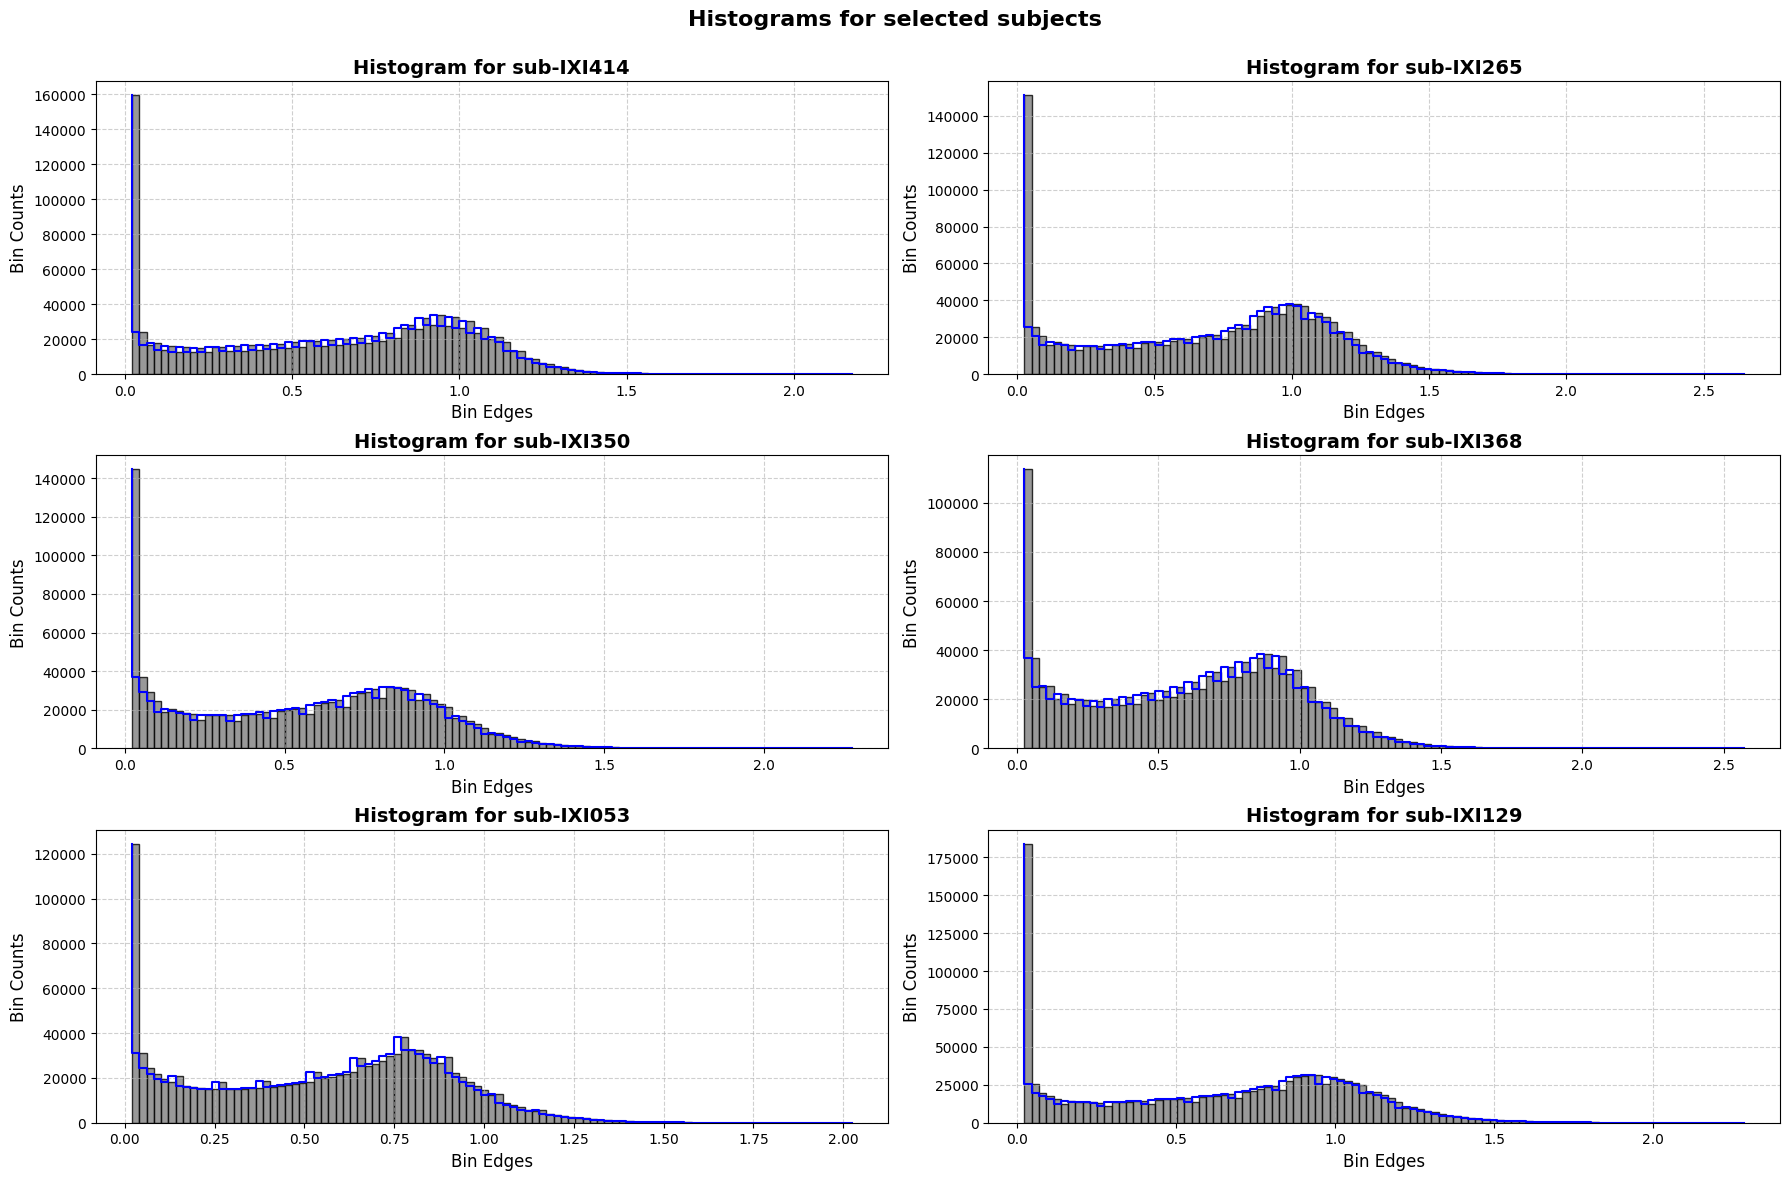

In [18]:
#plot 6 sample distributions
processor.plot_histogram_data(df_hists,df_bins)

In [17]:
# Test the hdf5 storage.
# Load the data from the HDF5 file
with pd.HDFStore('/home/hsreekri/Julearn_predictions/hist_data.h5', mode='r') as store:
    df_hists = store['histograms'] 
    df_bins = store['bins']  

print(df_hists.head())  
print(df_bins.head()) 



             Bin_1  Bin_2  Bin_3  Bin_4  Bin_5  Bin_6  Bin_7  Bin_8  Bin_9  \
sub-IXI350  144558  37218  29009  24683  18628  20545  19397  18515  17938   
sub-IXI487  164596  27431  22831  20156  18882  17696  20226  16712  16653   
sub-IXI154  155997  22580  18753  16764  15622  14627  14236  16163  13896   
sub-IXI123   97604  27323  26242  19500  21090  16290  18472  15049  17255   
sub-IXI129  184082  25404  19759  17296  15928  12363  14280  13814  13468   

            Bin_10  ...  Bin_91  Bin_92  Bin_93  Bin_94  Bin_95  Bin_96  \
sub-IXI350   14546  ...       3       6       5       5       2       3   
sub-IXI487   16832  ...       2       3       1       1       0       1   
sub-IXI154   13674  ...      21      12      13       5       3       2   
sub-IXI123   13878  ...      21      19      12       9       4       6   
sub-IXI129   13363  ...      12      14       5      11      10       6   

            Bin_97  Bin_98  Bin_99  Bin_100  
sub-IXI350       3       2       2